In [1]:
%matplotlib notebook
from ipynb.fs.defs.utilities import *

In [2]:
#Customized color bar 1

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 177/256, N)
vals[:, 1] = np.linspace(130/256, 78/256, N)
vals[:, 2] = np.linspace(180/256, 132/256, N)
newcmp = ListedColormap(vals)

#Customized color bar 2

vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 

vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)
cmp_blue_3col_inv = ListedColormap(cmp_blue_3col.colors[::-1])

# Workspace and analysis of 3d electromagnetic navigation systems

Demonstration of the workspace computation and analysis on 3d cases of electromagnetic navigation systems. This includes cases for three-coil and eight-coil systems.

## Three-coil systems

In [3]:
# Load systems calibration
cal_path_mns2 = 'models/mns_3coils_triangle.yaml'
model2 = ForwardModelMPEM()
model2.setCalibrationFile(cal_path_mns2)

In [4]:
Nx = 100
Ny = 100
Nz = 7

#Build initial box
pmin = [-0.15,-0.15,-0.1]
pmax = [0.15,0.15,0.1]

#Define inputs interval and task set
Imin = -3
Imax = 3
bmin = -0.02
bmax = 0.02

p_ws_2_in, p_ws_2_out,p_ws_2_side, kappa_2, mu_2, gci_2, minDist = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')

Nx = 1
Ny = 100
Nz = 100

#Build initial box
pmin = [0,-0.15,-0.1]
pmax = [0.,0.15,0.1]

p_x_in, p_x_out,p_x_side, kappa_1x, mu_1x, gci_1x, minDist  = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')

Nx = 100
Ny = 1
Nz = 100

#Build initial box
pmin = [-0.15,0.,-0.1]
pmax = [0.15,0.,0.1]

p_y_in, p_y_out,p_y_side, kappa_1y, mu_1y, gci_1y, minDist  = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')


Nx = 100
Ny = 100
Nz = 1

#Build initial box
pmin = [-0.15,-0.15,0.]
pmax = [0.15,0.15,0.]

p_z_in, p_z_out,p_z_side, kappa_1z, mu_1z, gci_1z, minDist  = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model2,'ellipsoid')

<IPython.core.display.Javascript object>


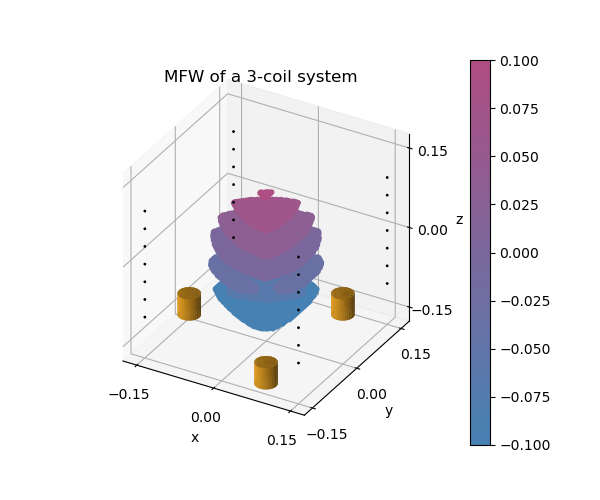

In [5]:
coil_length = 0.04
coil_radius = 0.02
lim = 0.17

fig = plt.figure(figsize=(6, 5))


ax = fig.gca(projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_2_in[:,0],p_ws_2_in[:,1],p_ws_2_in[:,2], alpha=1., s = 10, c=p_ws_2_in[:,2]-pmin[2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_2_side[:,0],p_ws_2_side[:,1],p_ws_2_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns2,ax)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('MFW of a 3-coil system')

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

plt.colorbar(s)

plt.show()

<IPython.core.display.Javascript object>


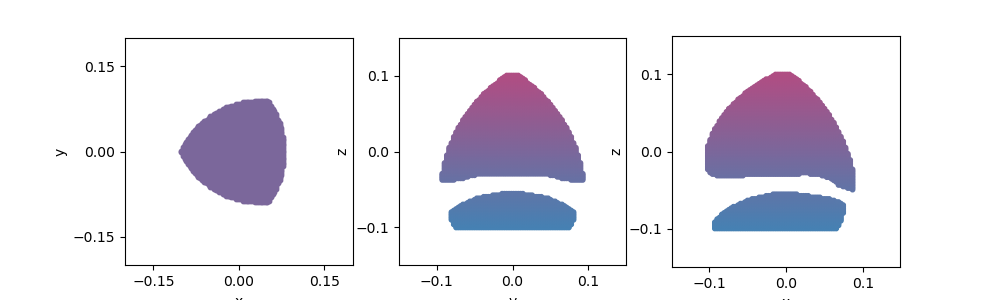

In [6]:
fig = plt.figure(figsize=(10, 3))

lim = 0.15


ax = fig.add_subplot(131)
ax.scatter(p_z_in[:,0],p_z_in[:,1],alpha=1., s = 10, color="#7B679B", rasterized=True)

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


ax = fig.add_subplot(132)
ax.scatter(p_x_in[:,1],p_x_in[:,2],alpha=1., s = 10, c=p_x_in[:,2]-pmin[2],cmap = newcmp, rasterized=True)

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_aspect('equal')
ax.set_xlabel('y')
ax.set_ylabel('z')

ax = fig.add_subplot(133)
ax.scatter(p_y_in[:,0],p_y_in[:,2],alpha=1., s = 10, c=p_y_in[:,2]-pmin[2],cmap = newcmp, rasterized=True)
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('z')

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.15, 0.15)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_aspect('equal')

plt.show()


## Eight-coil system

In [7]:
# Load systems calibration
cal_path_mns3 = 'models/mns_8coils_octomag.yaml'
model3 = ForwardModelMPEM()
model3.setCalibrationFile(cal_path_mns3)

In [8]:
#Dimensions for coils representation
coil_length = 0.05
coil_radius = 0.015

Nx = 50
Ny = 50
Nz = 4

#Build initial box
pmin = [-0.1,-0.1,-0.025]
pmax = [0.1,0.1,0.085]

#Define inputs interval and task set
Imin = -1
Imax = 1

bmin = -0.09
bmax = 0.09

gmin = -0.5
gmax = 0.5

In [9]:
#Field
p_ws_3_field_in, p_ws_3_field_out, p_ws_3_field_side, kappa_3_field, mu_3_field, gci_3_field, ad_3_field = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model3,'ellipsoid')

In [10]:
#Gradient
p_ws_3_gradient_in, p_ws_3_gradient_out, p_ws_3_gradient_side, kappa_3_gradient, mu_3_gradient, gci_3_gradient, ad_3_gradient = Ws3DGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,gmin,gmax,Imin,Imax,model3,'ellipsoid')

In [11]:
#Field and gradient
p_ws_3_bg_in, p_ws_3_bg_out, p_ws_3_bg_side, kappa_3_bg, mu_3_bg, gci_3_bg, ad_3_bg = Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,-0.01,0.01,-0.05,0.05,-5,5,model3,'ellipsoid')

<IPython.core.display.Javascript object>


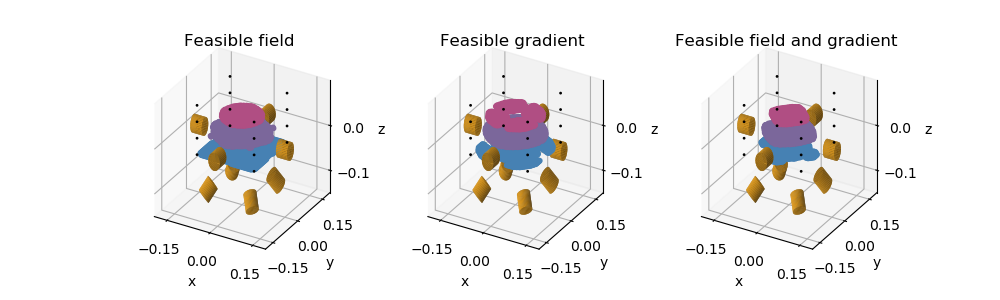

In [12]:
fig = plt.figure(figsize=(10,3))

coil_length = 0.04
coil_radius = 0.02

ax = fig.add_subplot(131,projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_3_field_in[:,0],p_ws_3_field_in[:,1],p_ws_3_field_in[:,2], alpha=1., s = 10, c=p_ws_3_field_in[:,2]-pmin[2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_3_field_side[:,0],p_ws_3_field_side[:,1],p_ws_3_field_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns3,ax,True)
ax.set_title('Feasible field')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(132,projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_3_gradient_in[:,0],p_ws_3_gradient_in[:,1],p_ws_3_gradient_in[:,2], alpha=1., s = 10, c=p_ws_3_gradient_in[:,2]-pmin[2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_3_gradient_side[:,0],p_ws_3_gradient_side[:,1],p_ws_3_gradient_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns3,ax,True)
ax.set_title('Feasible gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(133,projection='3d',proj_type = 'ortho')
s = ax.scatter(p_ws_3_bg_in[:,0],p_ws_3_bg_in[:,1],p_ws_3_bg_in[:,2], alpha=1., s = 10, c=p_ws_3_bg_in[:,2],cmap = newcmp,rasterized=True)
ax.scatter(p_ws_3_bg_side[:,0],p_ws_3_bg_side[:,1],p_ws_3_bg_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
PlotCoils3D(coil_length,coil_radius,cal_path_mns3,ax,True)
ax.set_title('Feasible field and gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

In [13]:
Nx = 1
Ny = 100
Nz = 100

#Build initial box
pmin = [0.,-0.1,-0.025]
pmax = [0.,0.1,0.085]

p_ws_3_field_x_in, p_ws_3_field_x_out, p_ws_3_field_x_side, kappa_3_field_x, mu_3_field_x, gci_3_field_x, ad_3_field_x = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,bmin,bmax,Imin,Imax,model3,'ellipsoid')
p_ws_3_gradient_x_in, p_ws_3_gradient_x_out, p_ws_3_gradient_x_side, kappa_3_gradient_x, mu_3_gradient_x, gci_3_gradient_x, ad_3_gradient_x = Ws3DGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,gmin,gmax,Imin,Imax,model3,'ellipsoid')
p_ws_3_bg_x_in, p_ws_3_bg_x_out, p_ws_3_bg_x_side, kappa_3_bg_x, mu_3_bg_x, gci_3_bg_x, ad_3_bg_x = Ws3DFieldGradientDeterminationDiscr(Nx,Ny,Nz,pmin,pmax,-0.01,0.01,-0.05,0.05,-5,5,model3,'ellipsoid')

<IPython.core.display.Javascript object>


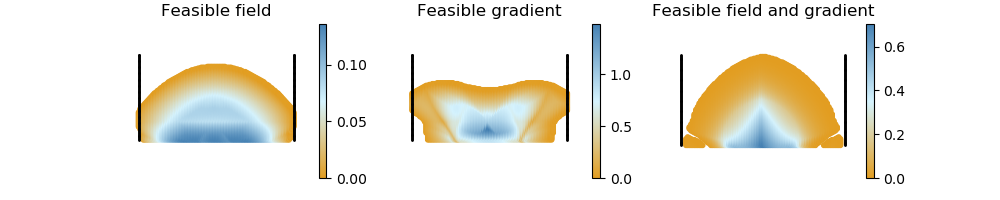

In [14]:
fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(131)
s = ax.scatter(p_ws_3_field_x_in[:,1],p_ws_3_field_x_in[:,2],alpha=1., s = 10, c=ad_3_field_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_field_x.max())
ax.scatter(p_ws_3_field_x_side[:,1],p_ws_3_field_x_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
ax.set_title('Feasible field')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(s, ticks=[0., 0.05, 0.1])
plt.show()
ax.axis('equal')
ax.axis('off')

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(132)
s = ax.scatter(p_ws_3_gradient_x_in[:,1],p_ws_3_gradient_x_in[:,2], alpha=1., s = 10, c=ad_3_gradient_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_gradient_x.max())
ax.scatter(p_ws_3_gradient_x_side[:,1],p_ws_3_gradient_x_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
ax.set_title('Feasible gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(s)
plt.show()
ax.axis('equal')
ax.axis('off')


ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))


ax = fig.add_subplot(133)
s = ax.scatter(p_ws_3_bg_x_in[:,1],p_ws_3_bg_x_in[:,2], alpha=1., s = 10,  c=ad_3_bg_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_bg_x.max())
ax.scatter(p_ws_3_bg_x_side[:,1],p_ws_3_bg_x_side[:,2], color='black',alpha=1., s = 1., rasterized=True)
ax.set_title('Feasible field and gradient')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(s)
plt.show()
ax.axis('equal')
ax.axis('off')



ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))